I'm not doing Exploratory Data Analysis (EDA) in this notebook, since there are quite a few notebooks with EDA already created. Instead my main goal is to achieve the highest F1 score (and through that the best AUC score obviously too). While analyzing the models predictions I realized from the very beginning that despite getting decent AUC scores all of them failed to provide sustainable precision. Their F1 score falls under 10%, which is unaccaptable in general. <br>
Unfortunately most of the published notebooks do not address this issue. <br>
This notebook provides comparison of leading models used for binary classification on tabular data. I also analyze how well these algorithms deal with categorical data being OneHot encoded vs being just encoded as labels.<br>
I also apply basic feature engineering to make a couple of synthetic features to see if that might help our models.<br>

<span style = 'font-size : medium; font-weight: bold; color : red'> Spoiler alert </span> - you can scroll down to find the curent winning solution at the bottom!<br>
<br>
Please note that for simplicity's sake I removed baseline models comparison, and quite a few fruitless experiments/approaches. If you'd like to see it please check version 15 and below of this notebook.

<p style = 'font-size : medium; font-weight: bold; color : brown'> Please Upvote this notebook if you like my work. </p>

# Import libraries

In [1]:
import pandas as pd, numpy as np
import os
import math
from math import ceil, floor, log
import random

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

from yellowbrick.classifier import ClassificationReport
import scikitplot as skplt

from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import catboost
print(catboost.__version__)
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier

import scikitplot as skplt

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


0.24.1


# Data loading and setup

In [2]:
SEED = 1970
random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
path = '../input/health-insurance-cross-sell-prediction/'

Data loading and preprocessing (feature engineering)...

Easy check proves that there is no empty or NaN data.

In [3]:
df_train = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "test.csv")
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64


In [4]:
col_list = df_train.columns.to_list()[1:]
df_train_corr = df_train.copy().set_index('id')
df_train_ones = df_train_corr.loc[df_train_corr.Response == 1].copy()

categorical_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']
text_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# code text categorical features
le = preprocessing.LabelEncoder()
for f in text_features :
    df_train_corr[f] = le.fit_transform(df_train_corr[f])
# change digital categorical datatype so CatBoost can deal with them
df_train_corr.Region_Code = df_train_corr.Region_Code.astype('int32')
df_train_corr.Policy_Sales_Channel = df_train_corr.Policy_Sales_Channel.astype('int32')

Lets check feature correlations.

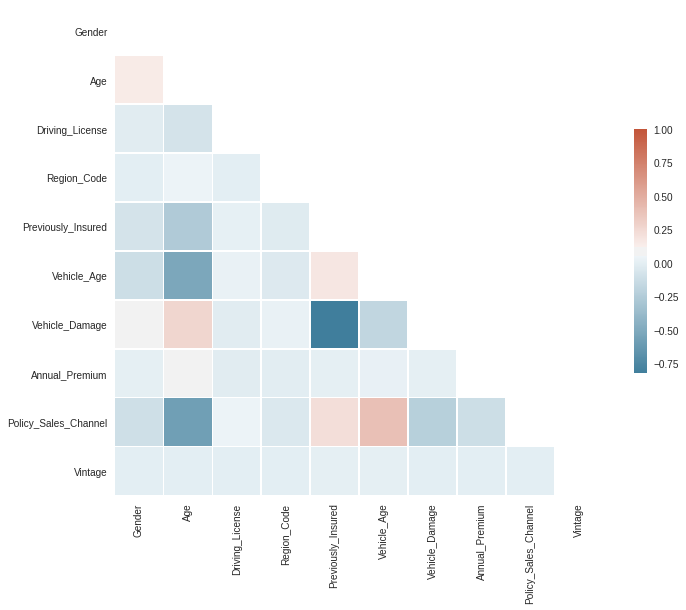

In [5]:
corr = df_train_corr.loc[:,:'Vintage'].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Looks like we have pretty strong negative correlation between 'Vehicle_Damage' and 'Previously_Insured' features, worth exploring it later.

In [6]:
bins = [10,20, 30, 40, 50, 60, 70, 80, 90, 100]
df_train_corr['bin_age'] = pd.cut(df_train_corr['Age'], bins)
df_train_corr['bin_age']
df_train_corr['age_bin_cat'] = le.fit_transform(df_train_corr['bin_age'])
df_train_corr['age_bin_cat'].value_counts()

1    155229
3     75941
2     55163
4     45305
5     27838
6     15272
0      6232
7       129
Name: age_bin_cat, dtype: int64

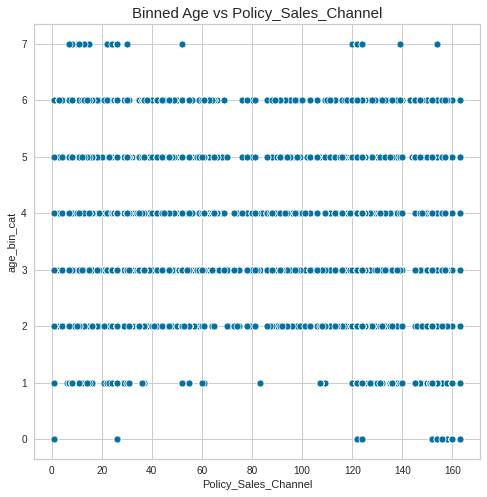

In [7]:
plt.figure(figsize = (8, 8))
sns.scatterplot(df_train_corr['Policy_Sales_Channel'],df_train_corr['age_bin_cat'])
plt.title('Binned Age vs Policy_Sales_Channel', fontsize = 15)
plt.show()

In [8]:
X = df_train_corr.loc[:,:'Vintage']
y = df_train_corr.Response
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state = SEED)
        
print(y_train.value_counts())
X_train.head()

0    267547
1     37340
Name: Response, dtype: int64


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
74933,1,23,1,31,0,1,1,2630.0,160,52
74767,0,24,1,14,1,1,0,36238.0,152,223
46813,0,25,1,21,0,1,1,32979.0,152,169
56592,0,25,1,5,1,1,0,24476.0,152,202
109992,1,30,1,8,1,0,0,32797.0,26,211


In [9]:
def plot_ROC(fpr, tpr, m_name):
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic for %s'%m_name, fontsize=20)
    plt.legend(loc="lower right", fontsize=16)
    plt.show()

# Oversampling and Feature Engineering
Brute-force oversampling of Positive Response class, and engineering 2 new synthetic features

In [10]:
def upsample(df, u_feature, n_upsampling):
    ones = df.copy()
    for n in range(n_upsampling):
        if u_feature == 'Annual_Premium':
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-1,1)* x *0.05) # change Annual_premiun in the range of 5%
        else:
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-5,5)) # change Age in the range of 5 years
                
        if n == 0:
            df_new = df.copy()
        else:
            df_new = pd.concat([df_new, df])
    return df_new

try:
    df_train_corr.drop(columns = ['bin_age'], inplace = True)
except:
    print('already deleted')        

df_train_mod = df_train_corr.copy()
df_train_mod['old_damaged'] = df_train_mod.apply(lambda x: pow(2,x.Vehicle_Age)+pow(2,x.Vehicle_Damage), axis =1)

# we shall preserve validation set without augmentation/over-sampling
df_temp, X_valid, _, y_valid = train_test_split(df_train_mod, df_train_mod['Response'], train_size=0.8, random_state = SEED)
X_valid = X_valid.drop(columns = ['Response'])

# upsampling Positive Response class only
df_train_up_a = upsample(df_temp.loc[df_temp['Response'] == 1], 'Age', 1)
df_train_up_v = upsample(df_temp.loc[df_temp['Response'] == 1], 'Vintage', 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [11]:
df_train_mod.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,age_bin_cat,old_damaged
id,,,,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217,1,3,6.0
2,1,76,1,3,0,0,0,33536.0,26,183,0,6,2.0
3,1,47,1,28,0,2,1,38294.0,26,27,1,3,6.0
4,1,21,1,11,1,1,0,28619.0,152,203,0,1,3.0
5,0,29,1,41,1,1,0,27496.0,152,39,0,1,3.0


In [12]:
df_ext = pd.concat([df_train_mod,df_train_up_a])
df_ext = pd.concat([df_ext,df_train_up_v])
X_train = df_ext.drop(columns = ['Response'])
y_train = df_ext.Response
# Xe = df_ext.drop(columns = ['Response'])
# ye = df_ext.Response
print('Train set target class count with over-sampling:')
print(y_train.value_counts())
print('Validation set target class count: ')
print(y_valid.value_counts())
X_train.head()

Train set target class count with over-sampling:
0    334399
1    121390
Name: Response, dtype: int64
Validation set target class count: 
0    66852
1     9370
Name: Response, dtype: int64


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,age_bin_cat,old_damaged
id,,,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217,3,6.0
2,1,76,1,3,0,0,0,33536.0,26,183,6,2.0
3,1,47,1,28,0,2,1,38294.0,26,27,3,6.0
4,1,21,1,11,1,1,0,28619.0,152,203,1,3.0
5,0,29,1,41,1,1,0,27496.0,152,39,1,3.0


Now we are going to check how XGBoost with the same parameters as baseline will predict using upsampled data with new features.

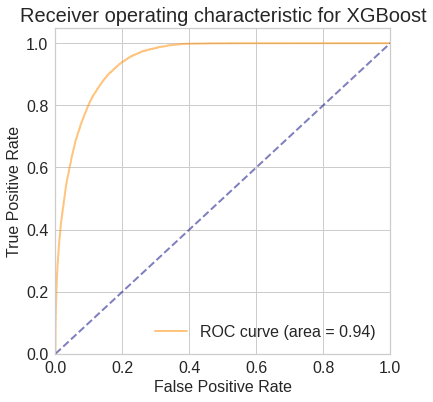

In [13]:
XGB_model_u = XGBClassifier(random_state = SEED, max_depth = 8, 
                            n_estimators = 3000, reg_lambda = 1.2, reg_alpha = 1.2, 
                            min_child_weight = 1, 
                            objective = 'binary:logistic',
                            learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

XGB_model_u.fit(X_train, y_train)
XGB_preds_u = XGB_model_u.predict_proba(X_valid)
XGB_score_u = roc_auc_score(y_valid, XGB_preds_u[:,1])
XGB_class_u = XGB_model_u.predict(X_valid)

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_u[:,1])
plot_ROC(fpr, tpr,'XGBoost')

ROC AUC score for XGBoost model with over-sampling + 2 new features: 0.9438
F1 score: 0.6418


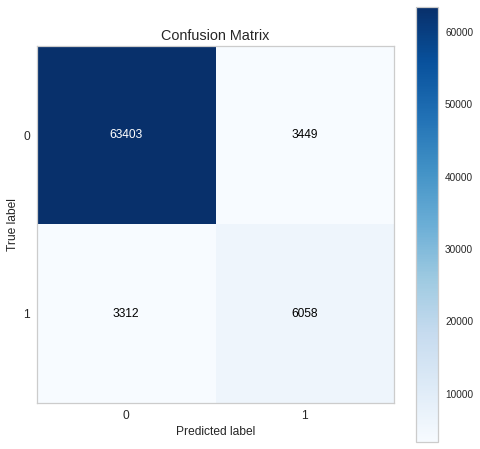

In [14]:
print('ROC AUC score for XGBoost model with over-sampling + 2 new features: %.4f'%XGB_score_u)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_u))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_u,
        figsize=(8,8))

Now we got much better True Positives, and quite acceptable AUC and f1 scores.

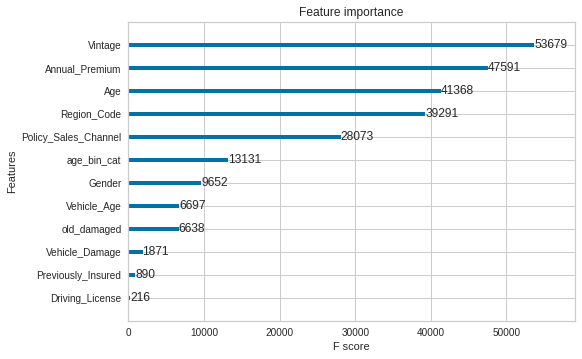

In [15]:
xgb.plot_importance(XGB_model_u)

<strike>  Since we saw that 2 features were correlated: 'Previously_Insured' and 'Vehicle_Damage', and the former is less significant for the decision making we'd drop it.</strike>

In [16]:
# X_train.drop(columns = ['Previously_Insured', 'Driving_License','Vehicle_Age','Vehicle_Damage'], inplace = True)
# X_valid.drop(columns = ['Previously_Insured', 'Driving_License','Vehicle_Age','Vehicle_Damage'], inplace = True)
# X_train.drop(columns = ['Previously_Insured'], inplace = True)
# X_valid.drop(columns = ['Previously_Insured'], inplace = True)

In [17]:
# XGB_model_ud = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 3000, reg_lambda = 1.2, reg_alpha = 1.2, 
#                           min_child_weight = 1, 
#                           objective = 'binary:logistic',
#                           learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

# XGB_model_ud.fit(X_train, y_train)
# XGB_preds_ud = XGB_model_ud.predict_proba(X_valid)
# XGB_score_ud = roc_auc_score(y_valid, XGB_preds_ud[:,1])
# XGB_class_ud = XGB_model_ud.predict(X_valid)

# (fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_ud[:,1])
# plot_ROC(fpr, tpr,'XGBoost')

In [18]:
# print('ROC AUC score for XGBoost model with over-sampling, and 4 features removed: %.4f'%XGB_score_ud)
# print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_ud))
# skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_ud,
#         figsize=(8,8))

In [19]:
# xgb.plot_importance(XGB_model_ud)

<strike>And it seems that dropping these features that were seemingly unimportant actually worsens the prediction...</strike>

# Ex-Winner
RF gave it's top spot in the last 3 days, so it's not even the 2nd nowadays. Also the result is different/worse now because RF did better on data set with some of the features dropped. New winners do better with extended data set instead.
> Random Forest applied to the augmented set with 2 engineered features got us the most remarkable score to date (9/25/2020):  AUC 92%, f1 56%, and I'm quite sure there is some room for improvement.

ROC AUC score for RandomForest model with over-sampling: 0.9111
Optimized RF f1-score 0.5429119590705607


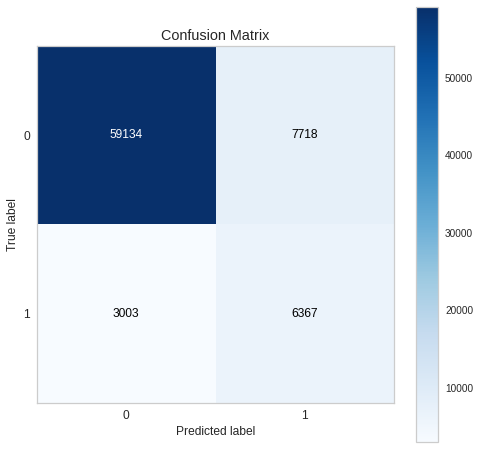

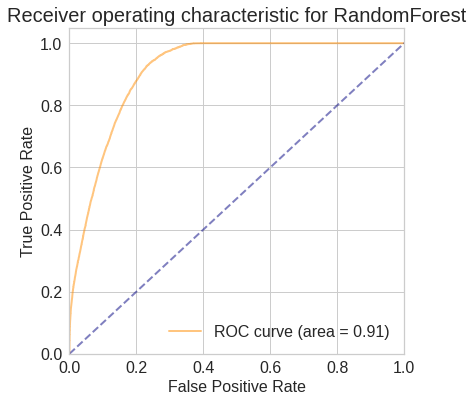

In [20]:
rf_params = {'max_depth': 20, 'n_estimators': 3000, 'min_samples_leaf': 1}
# rf_params = {'max_depth': 20, 'n_estimators': 300, 'min_samples_leaf': 1}
rf_params['random_state'] = SEED
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_valid)
rf_preds_prob = rf.predict_proba(X_valid)[:,1]

reg_score_uc = roc_auc_score(y_valid, rf_preds_prob, average = 'weighted')
print('ROC AUC score for RandomForest model with over-sampling: %.4f'%reg_score_uc)
print('Optimized RF f1-score', f1_score(y_valid, rf_preds))
skplt.metrics.plot_confusion_matrix(y_valid, rf_preds,figsize=(8,8))

(fpr, tpr, thresholds) = roc_curve(y_valid, rf_preds_prob)
plot_ROC(fpr, tpr,'RandomForest')

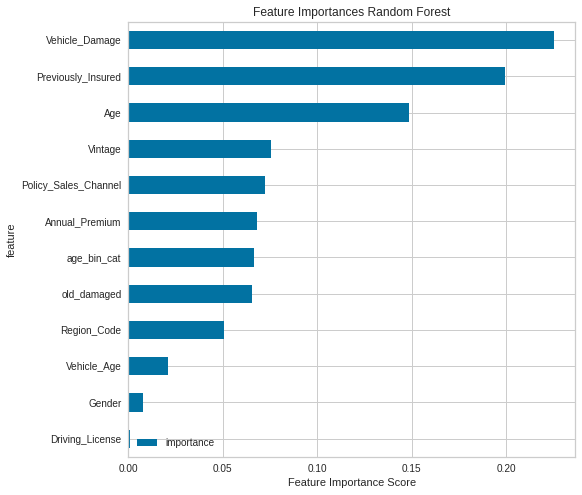

In [21]:
title="Feature Importances Random Forest"
feat_imp = pd.DataFrame({'importance':rf.feature_importances_}) 
feat_imp['feature'] = X_train.columns
feat_imp.sort_values(by='importance', ascending=True, inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()
# rf.get_params()

# And the winner is...


As of 9/27/2020 **CatBoost** is top contender.<br>
And now lets try to improve CatBoost predictions. We will use it's built-in capabilities to deal with categorecal features. Hopefully it will work better than XGBoost with OneHot encoded features.<br>
I tried it starting from 3000 iterations when it gave worse result than RF, but looking at the confusion matrix I saw potential for more precise prediction. So I started slightly tunining the parameters to get better results.

In [22]:
categorical_features1 = ['Gender',
 'age_bin_cat',
 'Region_Code',
 'old_damaged',
 'Policy_Sales_Channel']

X_train.old_damaged = X_train.old_damaged.astype('int32')
X_valid.old_damaged = X_valid.old_damaged.astype('int32')

In [23]:
Cat_model1 = CatBoostClassifier( iterations = 30000, 
                                random_seed = SEED, 
#                                 task_type = 'GPU',
                                task_type = 'CPU',
                                learning_rate=0.15,
                                random_strength=0.1,
                                depth=8,
                                loss_function='Logloss',
                                eval_metric='Logloss',
                                leaf_estimation_method='Newton',
                                subsample = 0.9,
                                rsm = 0.8,
                                custom_loss = ['AUC'] )
Cat_model1.fit(X_train, y_train, cat_features = categorical_features1, eval_set = (X_valid, y_valid), plot = False,
              early_stopping_rounds=50,verbose = 1000)

0:	learn: 0.5335063	test: 0.5012631	best: 0.5012631 (0)	total: 515ms	remaining: 4h 17m 28s
1000:	learn: 0.3172492	test: 0.2752382	best: 0.2752382 (1000)	total: 5m 54s	remaining: 2h 51m 13s
2000:	learn: 0.2909659	test: 0.2622839	best: 0.2622839 (2000)	total: 12m 3s	remaining: 2h 48m 44s
3000:	learn: 0.2694276	test: 0.2507047	best: 0.2507047 (3000)	total: 18m 16s	remaining: 2h 44m 28s
4000:	learn: 0.2512090	test: 0.2411363	best: 0.2411363 (3999)	total: 24m 28s	remaining: 2h 39m 1s
5000:	learn: 0.2353306	test: 0.2323545	best: 0.2323545 (5000)	total: 30m 42s	remaining: 2h 33m 28s
6000:	learn: 0.2212834	test: 0.2242916	best: 0.2242916 (6000)	total: 36m 58s	remaining: 2h 27m 53s
7000:	learn: 0.2088301	test: 0.2175906	best: 0.2175906 (7000)	total: 43m 14s	remaining: 2h 22m 2s
8000:	learn: 0.1978795	test: 0.2112747	best: 0.2112694 (7999)	total: 49m 31s	remaining: 2h 16m 11s
9000:	learn: 0.1875959	test: 0.2052362	best: 0.2052274 (8999)	total: 55m 50s	remaining: 2h 10m 16s
10000:	learn: 0.177806

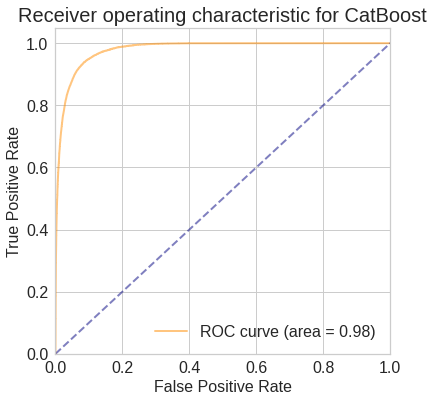

In [24]:
Cat_preds1 = Cat_model1.predict_proba(X_valid)
Cat_class1 = Cat_model1.predict(X_valid)
Cat_score1 = roc_auc_score(y_valid, Cat_preds1[:,1])

(fpr, tpr, thresholds) = roc_curve(y_valid, Cat_preds1[:,1])
plot_ROC(fpr, tpr, 'CatBoost')

ROC AUC score for CatBoost model with over-sampling: 0.9791
CatBoost f1-score 0.8014059753954305


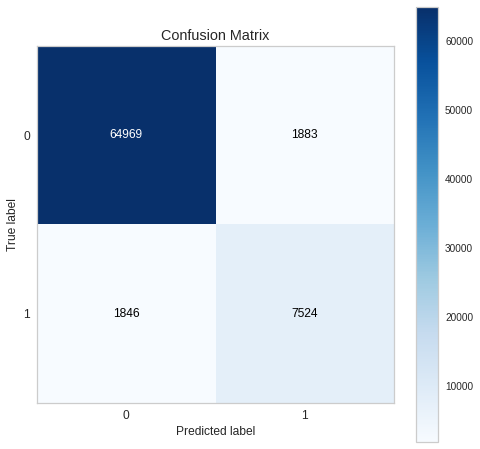

In [25]:
print('ROC AUC score for CatBoost model with over-sampling: %.4f'%Cat_score1)
print('CatBoost f1-score', f1_score(y_valid, Cat_class1))
skplt.metrics.plot_confusion_matrix(y_valid, Cat_class1,figsize=(8,8))

History of changes in parameters reflects how the scoring changes:
1. When parameters chosen as: ( iterations = 10000, random_seed = SEED, task_type = 'GPU', task_type = 'CPU', learning_rate=0.05, random_strength=0.1, depth=8,                                loss_function='Logloss', eval_metric='Logloss', leaf_estimation_method='Newton', subsample = 0.9, rsm = 0.8, custom_loss = ['AUC'] ) <br>
then we got: <br>
ROC AUC score for CatBoost model with over-sampling: 0.9111 <br>
CatBoost f1-score 0.5562159484893512
2. When I changed learning to 0.15 and limited iterations to 20000 I got: <br>
ROC AUC score for CatBoost model with over-sampling: 0.9659<br>
CatBoost f1-score 0.7399318133390156
3. When iterations were limited to 30000 it came to: <br>
ROC AUC score for CatBoost model with over-sampling: 0.9757 <br>
CatBoost f1-score 0.7840309910685461
4. When data set retained all features as opposed to dropping 4 less important ones in all previous attempts:<br>
ROC AUC score for CatBoost model with over-sampling: 0.9791<br>
CatBoost f1-score 0.8014059753954305

I decided to give another chance for XGBoost, as I've tried it on my local machine with full features set + 2 new features and upsampling and the result was almost phenomenal...

In [26]:
X_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,age_bin_cat,old_damaged
id,,,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217,3,6
2,1,76,1,3,0,0,0,33536.0,26,183,6,2
3,1,47,1,28,0,2,1,38294.0,26,27,3,6
4,1,21,1,11,1,1,0,28619.0,152,203,1,3
5,0,29,1,41,1,1,0,27496.0,152,39,1,3


In [27]:
XGB_model_l = XGBClassifier(random_state = SEED, max_depth = 8, 
                            n_estimators = 30000, 
                            reg_lambda = 1.2, reg_alpha = 1.2, 
                            min_child_weight = 1, 
                            objective = 'binary:logistic',
                            learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

XGB_model_l.fit(X_train, y_train,
                eval_set = [(X_valid, y_valid)],
                early_stopping_rounds=50,verbose = 1000)

[0]	validation_0-auc:0.81335
Will train until validation_0-auc hasn't improved in 50 rounds.
[1000]	validation_0-auc:0.90643
[2000]	validation_0-auc:0.92903
[3000]	validation_0-auc:0.94388
[4000]	validation_0-auc:0.95431
[5000]	validation_0-auc:0.96301
[6000]	validation_0-auc:0.96952
[7000]	validation_0-auc:0.97418
[8000]	validation_0-auc:0.97831
[9000]	validation_0-auc:0.98117
[10000]	validation_0-auc:0.98431
[11000]	validation_0-auc:0.98668
[12000]	validation_0-auc:0.98867
[13000]	validation_0-auc:0.99025
[14000]	validation_0-auc:0.99160
[15000]	validation_0-auc:0.99276
[16000]	validation_0-auc:0.99364
[17000]	validation_0-auc:0.99434
[18000]	validation_0-auc:0.99496
[19000]	validation_0-auc:0.99545
[20000]	validation_0-auc:0.99581
[21000]	validation_0-auc:0.99605
[22000]	validation_0-auc:0.99642
[23000]	validation_0-auc:0.99674
[24000]	validation_0-auc:0.99699
Stopping. Best iteration:
[24135]	validation_0-auc:0.99702



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0.3, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=30000, n_jobs=0,
              num_parallel_tree=1, random_state=1970, reg_alpha=1.2,
              reg_lambda=1.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
XGB_preds_l = XGB_model_l.predict_proba(X_valid)
XGB_score_l = roc_auc_score(y_valid, XGB_preds_l[:,1])
XGB_class_l = XGB_model_l.predict(X_valid)

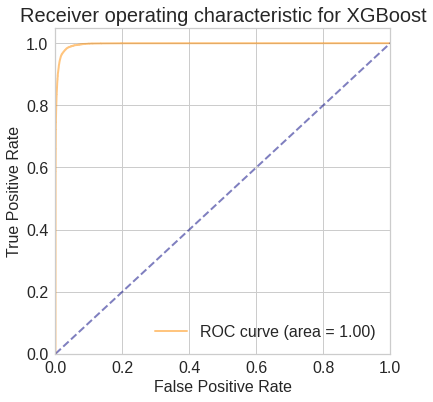

ROC AUC score for XGBoost model with over-sampling + 2 new features: 0.9970
F1 score: 0.9238


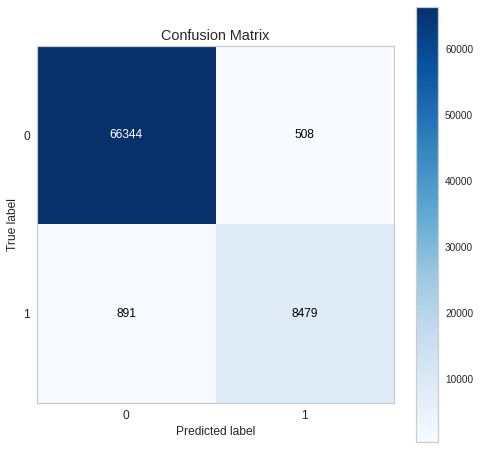

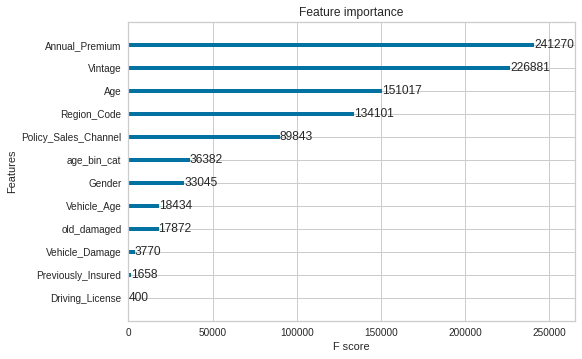

In [29]:
(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_l[:,1])
plot_ROC(fpr, tpr,'XGBoost')

print('ROC AUC score for XGBoost model with over-sampling + 2 new features: %.4f'%XGB_score_l)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_l))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_l,
        figsize=(8,8))

xgb.plot_importance(XGB_model_l)

# TO-DO
* <strike>Try to improve XGBoost and CatBoost through fine-tuning, and try to beat Random Forest on augmented data.    <br>
 We got CatBoost beating RandomForest and XGBoost successfully! Now we shall try to improve it even further :) <br>
* KFold croos-validation might help, but I don't expect it to give a breakthrough improvement, so it is a low priority for now. <br> </strike>
* And think of more feature engineering...<br>

<p style = 'font-size : medium; font-weight: bold; color : green'> More experiments coming. </p>

<strike>**Big question** - was AUC the right metric for this problem, or would F1 be better?</strike> <br>
<p style = 'font-size : medium; font-weight: bold; color : brown'> I'm quite sure now that the metric must be F1 for this task to produce usable predictions</p>